As descirbed earlier, it will be better to build two regressor, oone for low to medium wine quality regressor (quality = 3, 4, 5, 6) and one medium to high wine quality regressor (quality = 6, 7, 8, 9). 

This part of the code is to build two sepereated models, one for low to medium quality wine, and one for medium to high quality wine. The output was then assembled by the following rule:
(1) if the predicted quality from the ‘low to medium quality’ <6, take the prediction from the ‘low to medium quality’ model;
(2) if the predicted quality from the ‘medium to high quality’ >6, take the prediction from the ‘medium to high quality’ model;
(3) if the prediction is around 6, take the average values between the two models.

In [50]:
library(tidyverse)
library(caret)
library(plsRglm)
library(MASS)

In [2]:
script_dir = '/Users/yizheng/project_python3/inisght/AFS'

data_red = read.csv(paste(script_dir, "winequality-red.csv", sep = "/"), header = TRUE, sep = ";")
data_white = read.csv(paste(script_dir, "winequality-white.csv", sep = "/"), header = TRUE, sep = ";")
data <- rbind(data_red, data_white)

In [3]:
head(data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [4]:
unique(data$quality)

[1] 5 6 7 4 8 3 9

#### We will have two gourps with overlap:
1. quality (3, 4, 5, 6) - low group
2. quality (7, 8, 9) - low group opposite

3. quality(6, 7, 8, 9) - high group
4. quality(3, 4, 5) -high group opposite

We will build seperated regression model between group 1 and 3. The reason to keep the overlapping in the two groups (quality = 6) is to get a more robust model in the cut off point. If one data appears both in group 1 and 3, we take the average of the regression of prediciton as our final outcome.


In [5]:
data$'low_group' = 0 # if the data is in low quality group
data$'high_group' = 0 # if the data is in high quality group

data[c(which(data$quality<=6)),]$'low_group' = 1 # 3, 4, 5, 6
data[c(which(data$quality>=6)),]$'high_group' = 1 # 5, 6, 7, 8 9

In [6]:
head(data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,low_group,high_group
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1,0
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1,0
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,1,0
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1,1
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1,0
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,1,0


In [7]:
anyNA(data)

[1] FALSE

In [8]:
# Split the data into training and test set
set.seed(200)
training.samples <- data$quality %>%
createDataPartition(p = 0.8, list = FALSE)

train.data  <- data[training.samples, ]
test.data <- data[-training.samples, ]

In [9]:
y_var = c("quality", "low_group", "high_group")

In [10]:
myvars <- names(data) %in% c("quality", "low_group", "high_group")
X_train <- train.data[!myvars]
X_test <- test.data[!myvars]

In [11]:
y_train_quality = subset(train.data, select = c("quality") )
y_train_lg = subset(train.data, select = c("low_group") )
y_train_hg = subset(train.data, select = c("high_group") )

y_test_quality = subset(test.data, select = c("quality") )
y_test_lg = subset(test.data, select = c("low_group") )
y_test_hg = subset(test.data, select = c("high_group") )

## Part 2: build regression model for the two group of data
Now we will build two regression model, one for the high quality group and one for the low quality group

1. We have the training data that we know if it is in the low quality group, but the test data, we don't know, so the first thing to do is to use the previous trained classifer to find the test data for this group

2. We will need to do feature engineering as described earlier on the regression files to have four set of data: (1) raw data (2) normalized data (3) LDA feature extraction on 2nd order polynomial data (4)  LDA feature extraction on 3rd order polynomial data

3. Build PLS model for the 4 set of data and average the prediction results

### Get the training data of group 1 - low to mid quality wine

In [12]:
# take the training group which flag low_group as 1
train_group1 = train.data [c(which(train.data $low_group==1)),]

# remove the high_group label as we won't be using it 
train_group1 = subset(train_group1, select = -c(high_group))

# remove the low_group label as we have done training the classifer, 
# here we only need the wine quality
train_group1 = subset(train_group1, select = -c(low_group))

In [13]:
X_train_group1 = subset(train_group1, select = -c(quality))
y_train_group1 = subset(train_group1, select = c(quality))

In [14]:
head(train_group1)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


### Get the training data of group 2 - mid to high quality wine

In [15]:
# take the training group which flag low_group as 1
train_group2 = train.data [c(which(train.data $high_group==1)),]

# remove the high_group label as we won't be using it 
train_group2 = subset(train_group2, select = -c(high_group))

# remove the low_group label as we have done training the classifer, 
# here we only need the wine quality
train_group2 = subset(train_group2, select = -c(low_group))

In [16]:
X_train_group2 = subset(train_group2, select = -c(quality))
y_train_group2 = subset(train_group2, select = c(quality))

In [17]:
head(train_group2)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
4,11.2,0.280,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
8,7.3,0.650,0.00,1.2,0.065,15,21,0.9946,3.39,0.47,10.0,7
9,7.8,0.580,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,7
20,7.9,0.320,0.51,1.8,0.341,17,56,0.9969,3.04,1.08,9.2,6
25,6.9,0.400,0.14,2.4,0.085,21,40,0.9968,3.43,0.63,9.7,6
30,7.8,0.645,0.00,2.0,0.082,8,16,0.9964,3.38,0.59,9.8,6


## Part 1: build a regression model for low quality wine (quality <= 6)

#### Model1, PLS with raw data

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
____Component____ 7 ____
____Component____ 8 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.628425,0.2964587


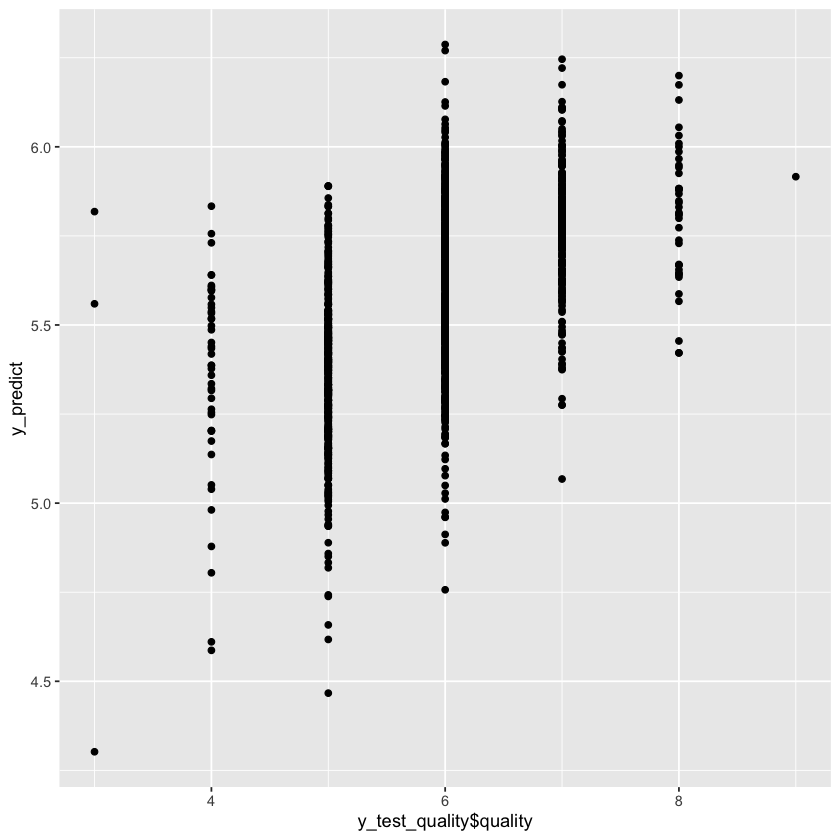

In [18]:
modpls_g <-plsRglm(quality~.,data=train_group1,8,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_g, newdata = X_test)
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(y_test_quality$quality, y_predict)) +
    geom_point()

data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test_quality$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test_quality$quality)
)

Store the prediction

In [19]:
final_predict_low = matrix(nrow = nrow(y_predict), ncol = 3)
final_predict_low[,1]  <- y_predict$y_predict

#### Model2, PLS with data (2nd order polynomial features with LDA extraction)

In [20]:
features_poly <- function(X_original, X_new){

    # This is a funciton to generate polynomial features
    # It multiply each feature of data frame X_new (x1, x2, x3)
    # by each feature in X_original (x1, x2, x3)
    # resulting in new features (x1, x2, x3, x1*x1, x1*x2, x1*x3, x2*x2, x2*x3, x3*x3)
   
    
    new_features <- X_original
    count <- ncol(X_original) # keep the original features before adding new one
    
    for(i in 1:ncol(X_original)){
        for(j in i:ncol(X_new)){
        
        new_features[,count] <- X_original[,i]*X_new[,j]
        count <- count +1
            }
    }
    return(new_features)
}

In [21]:
X_train_poly2 <- features_poly(X_train_group1, X_train_group1) # 2nd order polynominal
X_test_poly2 <- features_poly(X_test, X_test)  # 2nd order polynominal

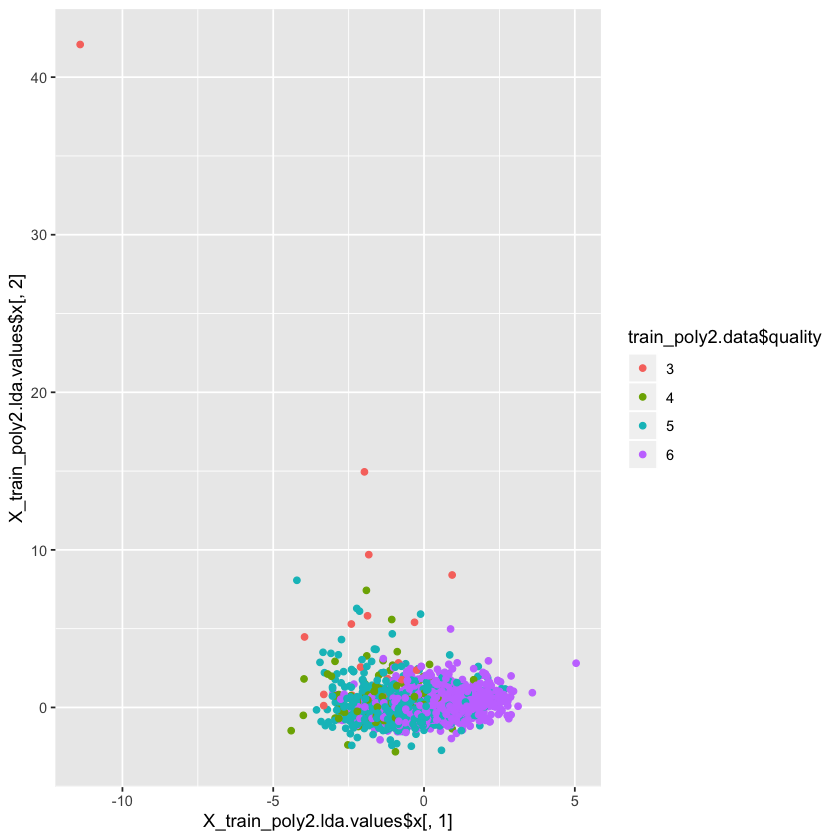

In [22]:
train_poly2.data <-X_train_poly2 
train_poly2.data["quality"] <- y_train_group1$quality

test_poly2.data <-X_test_poly2
test_poly2.data["quality"] <- y_test_quality$quality 

# convert to categorical data for LDA training
train_poly2.data$quality <- factor(y_train_group1$quality)
test_poly2.data$quality <- factor(y_test_quality$quality)

# build LDA model
X_train_poly2.lda <- lda( quality~ ., data=train_poly2.data)

# extract LDA factor values as new features
X_train_poly2.lda.values <- predict(X_train_poly2.lda)
X_test_poly2.lda.values <- predict(X_train_poly2.lda, newdata = X_test_poly2)

# plot the first two LDA factors
qplot(X_train_poly2.lda.values$x[,1], X_train_poly2.lda.values$x[,2], 
      colour = train_poly2.data$quality)



In [23]:
# convert back the categorical data to number for regression
y_train_group1$quality <- as.numeric(as.character(y_train_group1$quality))
y_test_quality$quality <- as.numeric(as.character(y_test_quality$quality))

# convert the LDA factors to data frame
X_train_poly2_lda <-as.data.frame(X_train_poly2.lda.values$x)
X_test_poly2_lda <- as.data.frame(X_test_poly2.lda.values$x)

# attach the y value into the data
train_poly2_lda <- X_train_poly2_lda
train_poly2_lda["quality"] <- y_train_group1$quality

test_poly2_lda <- X_test_poly2_lda
test_poly2_lda["quality"] <- y_test_quality$quality

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.6092008,0.3094822


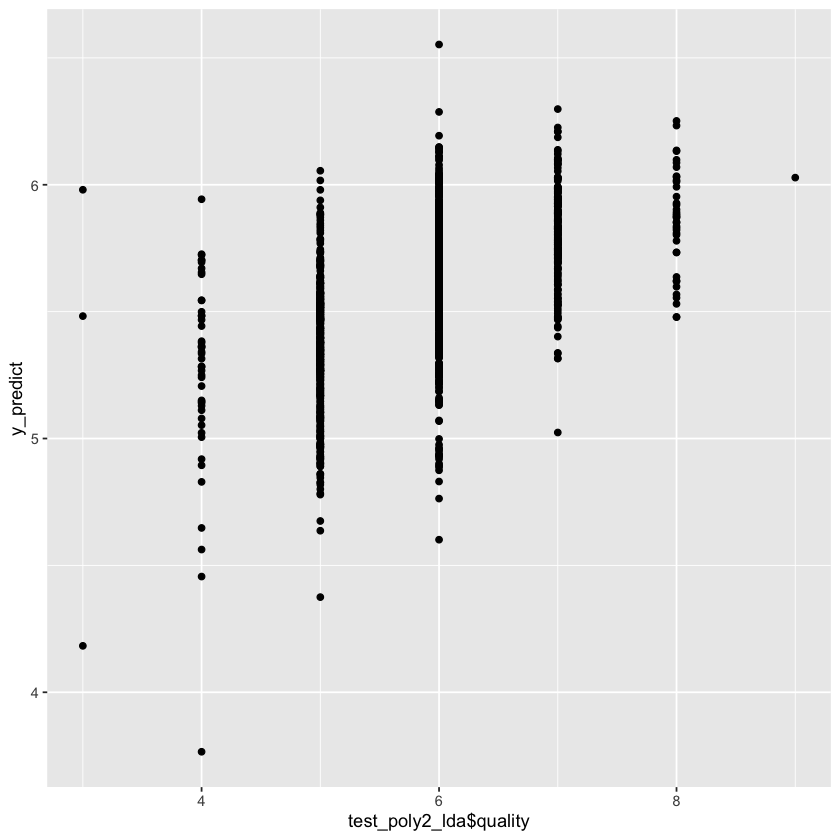

In [24]:
modpls_g <-plsRglm(quality~.,data=train_poly2_lda,1,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_g, newdata = X_test_poly2_lda )
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(test_poly2_lda$quality, y_predict)) +
    geom_point()

data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test_quality$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test_quality$quality)
)

In [25]:
final_predict_low[,2]  <- y_predict$y_predict

#### Model3, PLS with data (3rd order polynomial features with LDA extraction)

3rd order polynominal featuers:

In [26]:
X_train_poly2 <- features_poly(X_train_group1, X_train_group1) # 2nd order polynominal
X_test_poly2 <- features_poly(X_test, X_test)  # 2nd order polynominal

X_train_poly3 <- features_poly(X_train_group1,X_train_poly2) # 2nd order polynominal
X_test_poly3 <- features_poly(X_test,X_test_poly2)  # 2nd order polynominal

Prepare data for LDA feature extraction

In [27]:
train_poly3.data <-X_train_poly3 
train_poly3.data["quality"] <- y_train_group1$quality

test_poly3.data <-X_test_poly3
test_poly3.data["quality"] <- y_test_quality$quality 

# convert to categorical data for LDA training
train_poly3.data$quality <- factor(y_train_group1$quality)
test_poly3.data$quality <- factor(y_test_quality$quality)

Extract features using LDA

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

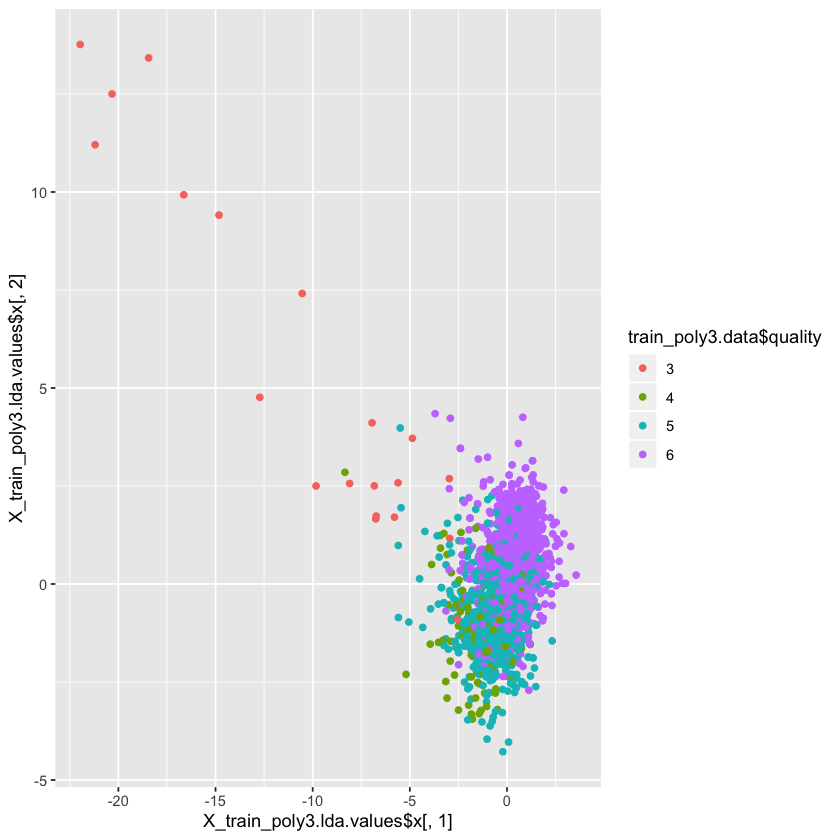

In [28]:
# build LDA model
X_train_poly3.lda <- lda( quality~ ., data=train_poly3.data)

# extract LDA factor values as new features
X_train_poly3.lda.values <- predict(X_train_poly3.lda)
X_test_poly3.lda.values <- predict(X_train_poly3.lda, newdata = X_test_poly3)

# plot the first two LDA factors
qplot(X_train_poly3.lda.values$x[,1], X_train_poly3.lda.values$x[,2], 
      colour = train_poly3.data$quality)



Prepare data for PLS

In [29]:
# convert back the categorical data to number for regression
y_train_group1$quality <- as.numeric(as.character(y_train_group1$quality))
y_test_quality$quality <- as.numeric(as.character(y_test_quality$quality))

# convert the LDA factors to data frame
X_train_poly3_lda <-as.data.frame(X_train_poly3.lda.values$x)
X_test_poly3_lda <- as.data.frame(X_test_poly3.lda.values$x)

# attach the y value into the data
train_poly3_lda <- X_train_poly3_lda
train_poly3_lda["quality"] <- y_train_group1$quality

test_poly3_lda <- X_test_poly2_lda
test_poly3_lda["quality"] <- y_test_quality$quality

Build the PLS model based on the LDA featueres extracted from 3rd order polynomial 

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.6310984,0.02742769


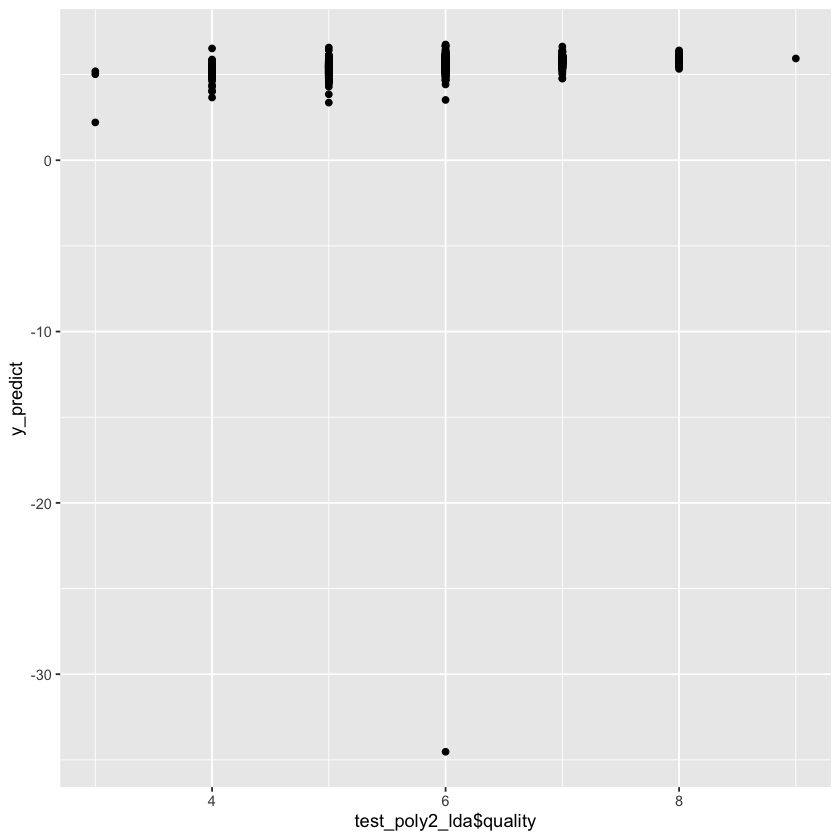

In [30]:
modpls_g <-plsRglm(quality~.,data=train_poly3_lda,3,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_g, newdata = X_test_poly3_lda )
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(test_poly2_lda$quality, y_predict)) +
    geom_point()

data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test_quality$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test_quality$quality)
)



In [31]:
final_predict_low[,3]  <- y_predict$y_predict

### Build the high quality wine predictor

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Component____ 4 ____
____Component____ 5 ____
____Component____ 6 ____
____Component____ 7 ____
____Component____ 8 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.7353228,0.2844989


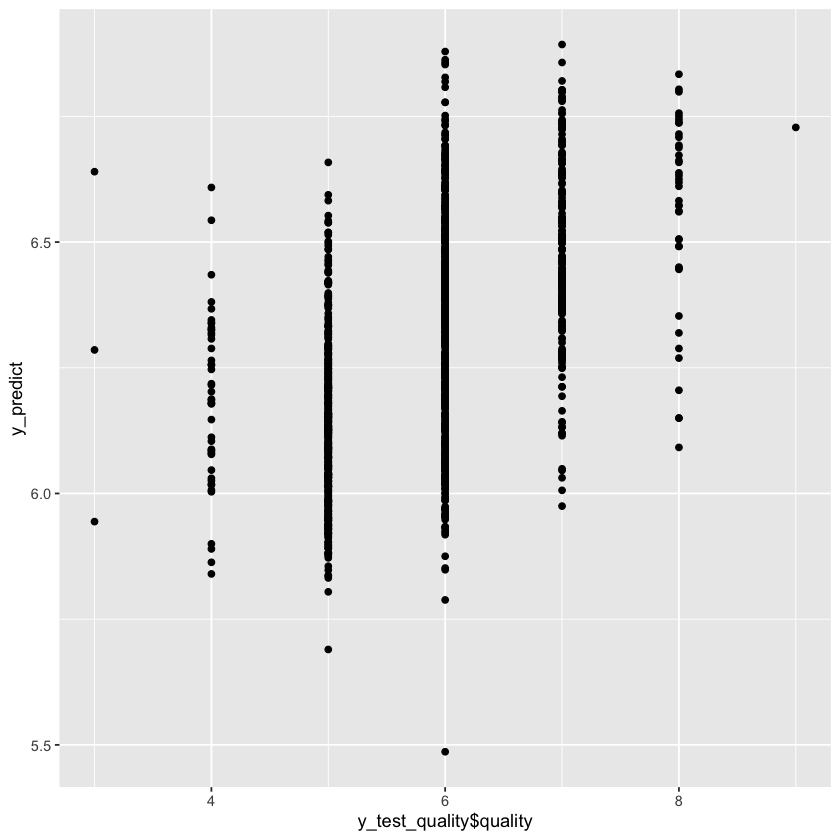

In [32]:
modpls_g <-plsRglm(quality~.,data=train_group2,8,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_g, newdata = X_test)
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(y_test_quality$quality, y_predict)) +
    geom_point()

data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test_quality$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test_quality$quality)
)



In [33]:
final_predict_high = matrix(nrow = nrow(y_predict), ncol = 3)
final_predict_high[,1]  <- y_predict$y_predict

Model 2

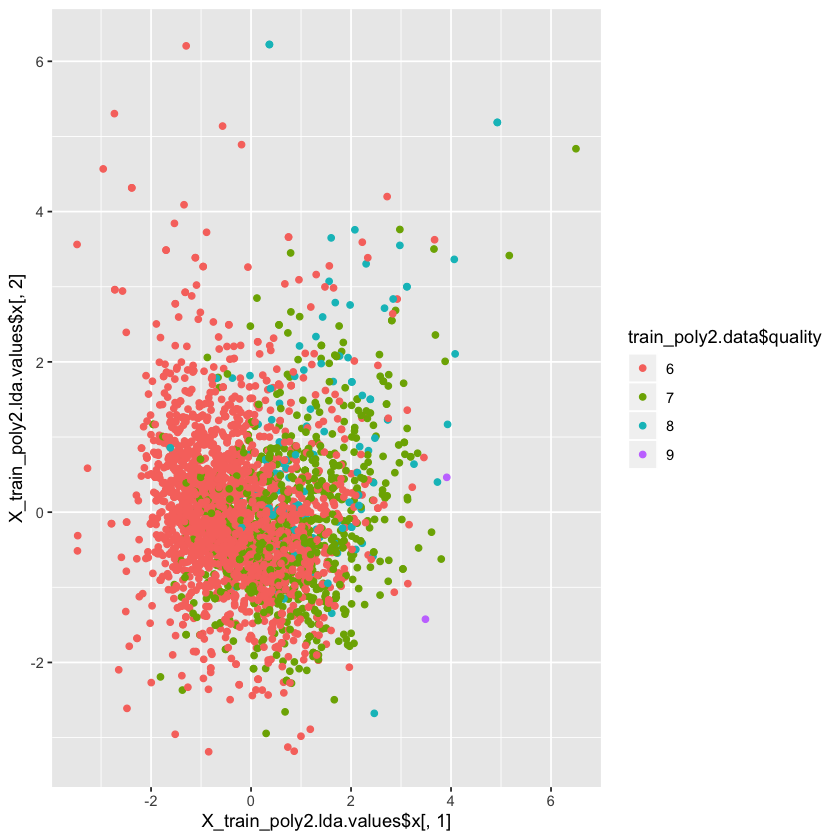

In [34]:
X_train_poly2 <- features_poly(X_train_group2, X_train_group2) # 2nd order polynominal
X_test_poly2 <- features_poly(X_test, X_test)  # 2nd order polynominal

train_poly2.data <-X_train_poly2 
train_poly2.data["quality"] <- y_train_group2$quality

test_poly2.data <-X_test_poly2
test_poly2.data["quality"] <- y_test_quality$quality 

# convert to categorical data for LDA training
train_poly2.data$quality <- factor(y_train_group2$quality)
test_poly2.data$quality <- factor(y_test_quality$quality)

# build LDA model
X_train_poly2.lda <- lda( quality~ ., data=train_poly2.data)

# extract LDA factor values as new features
X_train_poly2.lda.values <- predict(X_train_poly2.lda)
X_test_poly2.lda.values <- predict(X_train_poly2.lda, newdata = X_test_poly2)

# plot the first two LDA factors
qplot(X_train_poly2.lda.values$x[,1], X_train_poly2.lda.values$x[,2], 
      colour = train_poly2.data$quality)



In [35]:
# convert back the categorical data to number for regression
y_train_group2$quality <- as.numeric(as.character(y_train_group2$quality))
y_test_quality$quality <- as.numeric(as.character(y_test_quality$quality))

# convert the LDA factors to data frame
X_train_poly2_lda <-as.data.frame(X_train_poly2.lda.values$x)
X_test_poly2_lda <- as.data.frame(X_test_poly2.lda.values$x)

# attach the y value into the data
train_poly2_lda <- X_train_poly2_lda
train_poly2_lda["quality"] <- y_train_group2$quality

test_poly2_lda <- X_test_poly2_lda
test_poly2_lda["quality"] <- y_test_quality$quality

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.7171386,0.2500898


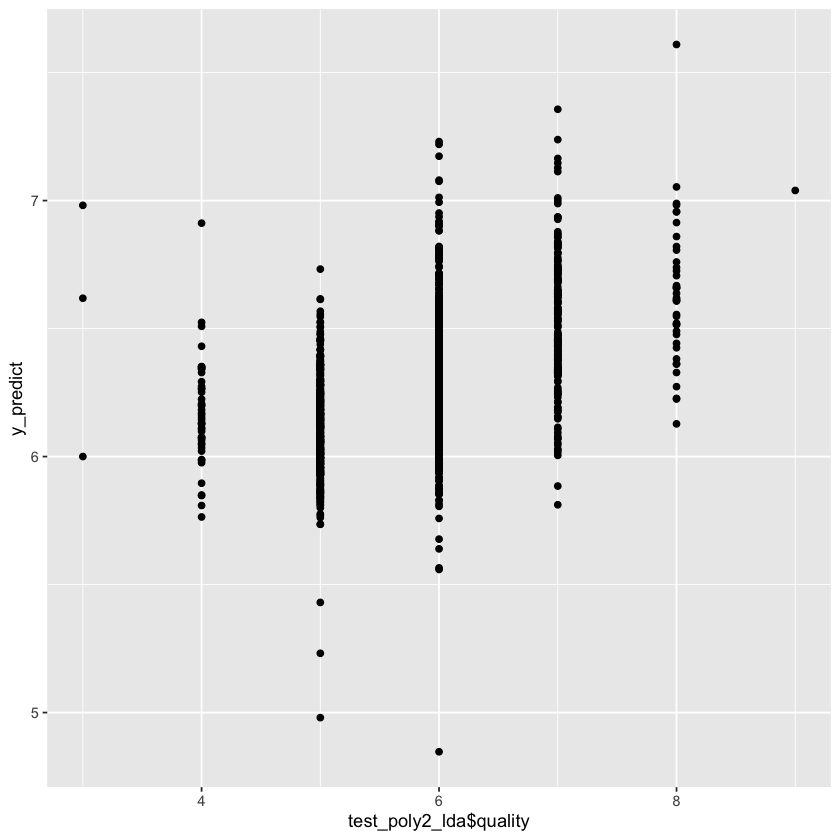

In [36]:
modpls_g <-plsRglm(quality~.,data=train_poly2_lda,1,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_g, newdata = X_test_poly2_lda )
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(test_poly2_lda$quality, y_predict)) +
    geom_point()


data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test_quality$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test_quality$quality)
)

In [37]:
final_predict_high[,2]  <- y_predict$y_predict

### Model 3

In [38]:
X_train_poly2 <- features_poly(X_train_group2, X_train_group2) # 2nd order polynominal
X_test_poly2 <- features_poly(X_test, X_test)  # 2nd order polynominal

X_train_poly3 <- features_poly(X_train_group2,X_train_poly2) # 2nd order polynominal
X_test_poly3 <- features_poly(X_test,X_test_poly2)  # 2nd order polynominal

In [39]:
train_poly3.data <-X_train_poly3 
train_poly3.data["quality"] <- y_train_group2$quality

test_poly3.data <-X_test_poly3
test_poly3.data["quality"] <- y_test_quality$quality 

# convert to categorical data for LDA training
train_poly3.data$quality <- factor(y_train_group2$quality)
test_poly3.data$quality <- factor(y_test_quality$quality)

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

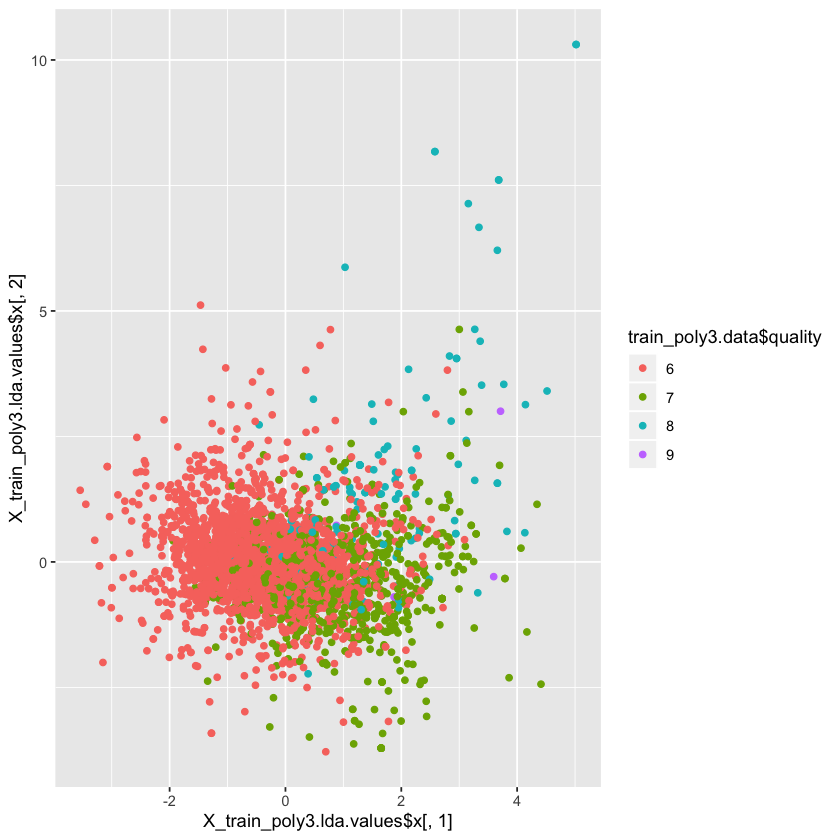

In [40]:
# build LDA model
X_train_poly3.lda <- lda( quality~ ., data=train_poly3.data)

# extract LDA factor values as new features
X_train_poly3.lda.values <- predict(X_train_poly3.lda)
X_test_poly3.lda.values <- predict(X_train_poly3.lda, newdata = X_test_poly3)

# plot the first two LDA factors
qplot(X_train_poly3.lda.values$x[,1], X_train_poly3.lda.values$x[,2], 
      colour = train_poly3.data$quality)


In [41]:
# convert back the categorical data to number for regression
y_train_group2$quality <- as.numeric(as.character(y_train_group2$quality))
y_test_quality$quality <- as.numeric(as.character(y_test_quality$quality))

In [42]:
# convert the LDA factors to data frame
X_train_poly3_lda <-as.data.frame(X_train_poly3.lda.values$x)
X_test_poly3_lda <- as.data.frame(X_test_poly3.lda.values$x)



In [43]:
# attach the y value into the data
train_poly3_lda <- X_train_poly3_lda
train_poly3_lda["quality"] <- y_train_group2$quality

test_poly3_lda <- X_test_poly2_lda
test_poly3_lda["quality"] <- y_test_quality$quality

____************************************************____

Family: gaussian 
Link function: identity 

____Component____ 1 ____
____Component____ 2 ____
____Component____ 3 ____
____Predicting X without NA neither in X or Y____
****________________________________________________****



Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”

MAE,Rsquare
<dbl>,<dbl>
0.7658449,0.01155688


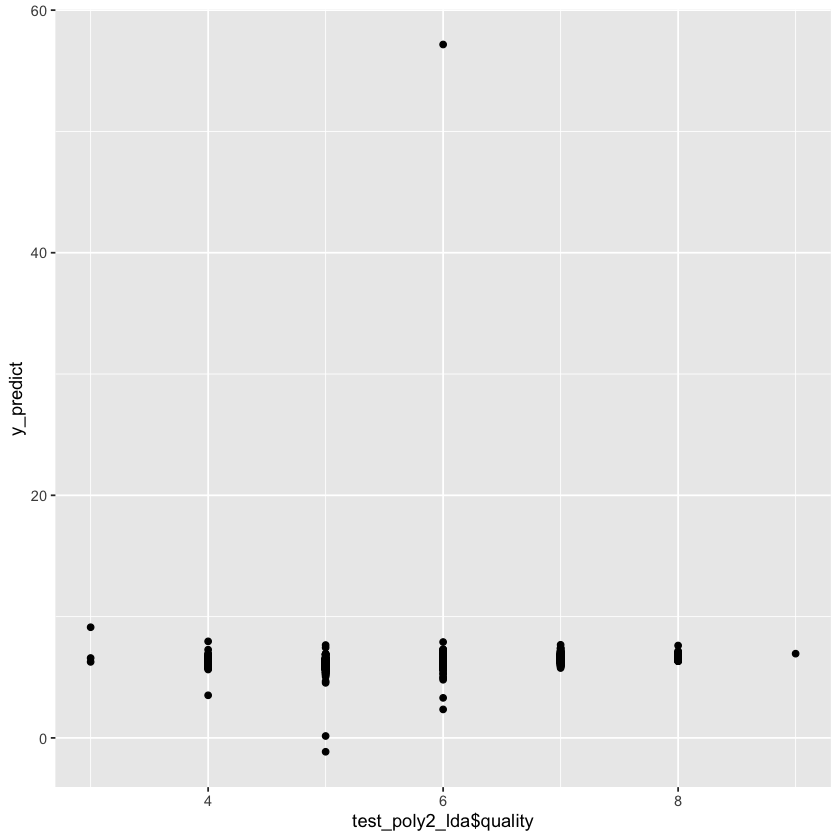

In [44]:
modpls_g <-plsRglm(quality~.,data=train_poly3_lda,3,
                      modele="pls-glm-family",family=gaussian())

y_predict <- predict(modpls_g, newdata = X_test_poly3_lda )
y_predict <- data.frame(y_predict)

y_predict %>%
  ggplot(aes(test_poly2_lda$quality, y_predict)) +
    geom_point()


data.frame(
  MAE = caret::MAE(y_predict$y_predict, y_test_quality$quality),
  Rsquare = caret::R2(y_predict$y_predict, y_test_quality$quality)
)


In [45]:
final_predict_high[,3]  <- y_predict$y_predict

### Combining all predictions

In [46]:
final_predict_high = 
rowMeans(final_predict_high, na.rm = FALSE, dims = 1)

In [47]:
final_predict_low = 
rowMeans(final_predict_low, na.rm = FALSE, dims = 1)

In [48]:
final = y_predict$y_predict

# if the prediction value is smaller than 6 in the low predictor 
# take the prediction from the low prediction
final[which(final_predict_low<6)] = 
final_predict_low[which(final_predict_low<6)]

# if the prediction value is larger than 7 in the high predictor 
# take the prediction from the high prediction
final[which(final_predict_high>7)] = 
final_predict_high[which(final_predict_high>7)]

# if the low pre
# take the average

index1 = which(final_predict_low<6 & final_predict_high>6)
final[index1]=(final_predict_low[index1]+final_predict_high[index1])/2
index_low = which(final<3)
final[index_low] = 6 # outlier give majority prediciton class

index_high = which(final>9)
final[index_high] = 6 # outlier give majority prediciton class
final <- as.data.frame(final)

MAE,Rsquare
<dbl>,<dbl>
0.5603846,0.2902672


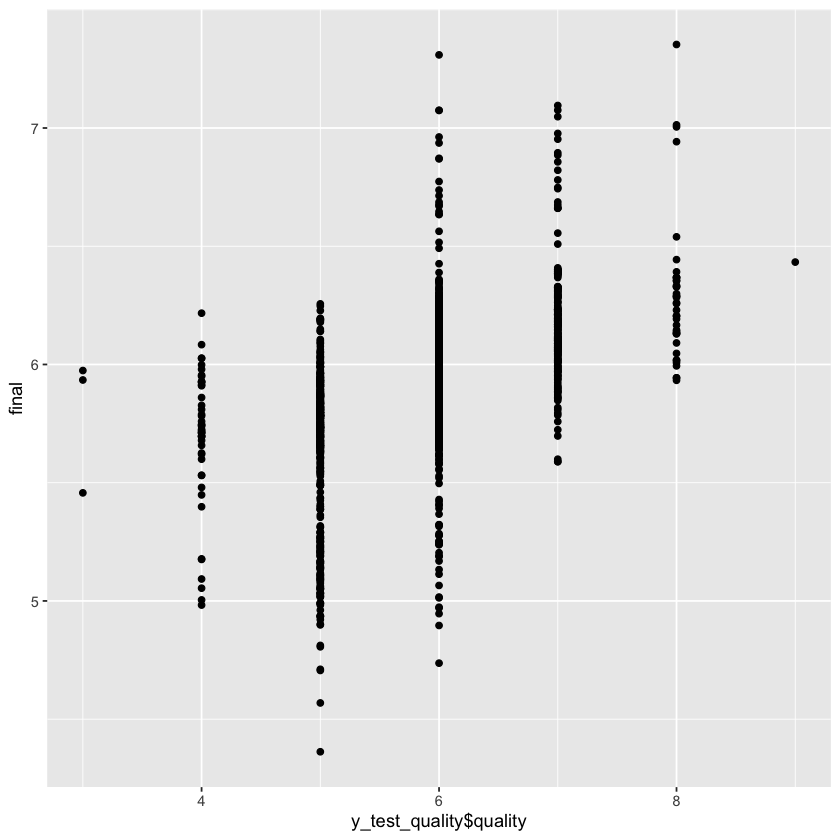

In [49]:
final %>%
  ggplot(aes(y_test_quality$quality, final)) +
    geom_point()

data.frame(
  MAE = caret::MAE(final$final, y_test_quality$quality),
  Rsquare = caret::R2(final$final, y_test_quality$quality)
)